In [6]:
import Pkg, Revise
using DrWatson
@quickactivate "sst-mot-analysis"

using GH19, TMI

import DrWatson: datadir, srcdir, plotsdir
!isdir(plotsdir()) && mkpath(plotsdir()) 

include(srcdir("CondaSSL.jl"))
include(srcdir("TMI_utils.jl"))

using PythonPlot, PythonCall

using NaNStatistics, Interpolations, 
      Statistics, LinearAlgebra

const mtpl = pyimport("matplotlib");
const cartopy = pyimport("cartopy");
const matplotlib = pyimport("matplotlib");
const sns = pyimport("seaborn");
const cm = pyimport("cmocean.cm")

mtpl.rcParams["figure.dpi"] = 100
ccrs = cartopy.crs

custom_style = Dict("text.color" => "black")
sns.set_theme(context="notebook", style="ticks", palette = "colorblind", rc=custom_style, font_scale = 1.2)
ccrs = cartopy.crs;
cfeature = cartopy.feature

Python: <module 'cartopy.feature' from '/Users/anthonymeza/Library/CloudStorage/OneDrive-MassachusettsInstituteofTechnology/Documents/GitHub/sst-mot-analysis/.CondaPkg/.pixi/envs/default/lib/python3.12/site-packages/cartopy/feature/__init__.py'>

In [7]:
include(srcdir("load_GH19.jl"))
include(srcdir("decompose_discrete.jl"))
include(srcdir("blocksum.jl"))
include(srcdir("IntersectionFunctions.jl"))

 takes about 10 minutes
Theta_OPT-0015.nc already downloaded; use `force=true` to re-download
Theta_anom_OPT-0015.nc already downloaded; use `force=true` to re-download


plot_map_and_zonal (generic function with 1 method)

In [8]:
function get_area_normalized_volume_filled_bc(TMIversion,Alu,γ)
    volume = volumefilled(TMIversion,Alu,γ); 
    volume = (10 .^ volume.tracer)
    volume = BoundaryCondition(volume,(γ.lon,γ.lat),γ.depth[1],3,1,γ.wet[:, :, 1],:V,"volume filled by surface gridcell per area","m³/m²")
    return 1 * volume
end

function get_volume_filled_bc(volume_normalized, γ, areao)
    volume = volume_normalized.tracer .* Float64.(areao.tracer)
    volume = BoundaryCondition(volume,(γ.lon,γ.lat),γ.depth[1],3,1,volume_normalized.wet,:V,"volume filled by surface gridcell","m³")
    return 1 * volume
end

function get_MOT_and_SST(TMIfile::String, γ::Grid)
    θ̄ = readfield(TMIfile, "θ", γ); #true mean
    volume = cellvolume(γ).tracer 
    θ̄_MOT = nansum(θ̄.tracer .* volume) / nansum(volume)
    θ̄_SST = getsurfaceboundary(θ̄);

    return θ̄_MOT, θ̄_SST
end

function get_MOT_and_SST(θ̄::Field, γ::Grid)
    volume = cellvolume(γ).tracer 
    θ̄_MOT = nansum(θ̄.tracer .* volume) / nansum(volume)
    θ̄_SST = getsurfaceboundary(θ̄);

    return θ̄_MOT, θ̄_SST
end

surfacecellarea(γ) = cellarea(γ)

surfacecellarea (generic function with 1 method)

#### Load in LGM and PI equillibrium temperatures

In [9]:
###### LOAD LGM ###########
TMI_version = "LGM_90x45x33_G14"
A, Alu, γ_lgm, TMIfile, L, B = config(DrWatson.datadir(), "TMI_" * TMI_version * "_compressed.nc")

volume_LGM_normalized = get_area_normalized_volume_filled_bc(TMIversion,Alu,γ_lgm)

volume_lgm = get_volume_filled_bc(volume_LGM_normalized, γ_lgm, surfacecellarea(γ_lgm))

θ̄_LGM_MOT, θ̄_LGM_SST = get_MOT_and_SST(TMIfile, γ_lgm);

###### LOAD PREINDUSTRIAL ###########
TMI_version = GH19.TMIversion();
A, Alu, γ_mod, TMIfile, L, B = config(TMI_version); 
TMIfile = TMI.pkgdatadir("TMI_"*TMI_version*".nc")

volume_mod_normalized_fine = get_area_normalized_volume_filled_bc(TMIversion,Alu,γ_mod)

volume_mod_fine = get_volume_filled_bc(volume_mod_normalized_fine, γ_mod, surfacecellarea(γ_mod))
θ̄GH19 = load_GH19_equillibrium()
θ̄_mod_MOT, θ̄_mod_SST_fine = get_MOT_and_SST(θ̄GH19, γ_mod);

Form water-mass matrix A
  0.257522 seconds (643.32 k allocations: 67.746 MiB, 5.25% gc time, 92.20% compilation time)
LU factorization of A
  0.777704 seconds (586.66 k allocations: 534.656 MiB, 14.82% gc time, 11.09% compilation time)
circulation matrix L=
  0.092931 seconds (83.36 k allocations: 4.411 MiB, 98.06% compilation time)
Boundary matrix B=
  0.020485 seconds (15.98 k allocations: 828.055 KiB, 93.08% compilation time)
Form water-mass matrix A
  0.069601 seconds (35.20 k allocations: 128.208 MiB, 14.86% gc time, 15.46% compilation time)
LU factorization of A
  4.196398 seconds (87 allocations: 2.810 GiB, 0.21% gc time)
circulation matrix L=
  0.205412 seconds (8.35 M allocations: 235.296 MiB, 6.67% gc time, 37.47% compilation time)
Boundary matrix B=
  0.014641 seconds (6.19 k allocations: 7.271 MiB, 20.38% compilation time)
Form water-mass matrix A
  0.040173 seconds (5.23 k allocations: 122.818 MiB, 29.01% gc time)
LU factorization of A
  4.778850 seconds (88 allocations: 

#### Coarse Grain PI output 

In [10]:
#coarse grain GH19 grid from 2x2 to 4x4
weights = volume_mod_fine.tracer ./ nansum(volume_mod_fine.tracer)
weights[isnan.(weights)] .= 0.0

oarea_mod_coarse = coarse_grain_boundary_condition(
    surfacecellarea(γ_mod), γ_mod, γ_lgm,
    2, 2;
    method = :sum, use_area_weights = false, weights = nothing)

volume_mod = coarse_grain_boundary_condition(
    volume_mod_fine, γ_mod, γ_lgm,
    2, 2;
    method = :sum, use_area_weights = false, weights = nothing)

θ̄_mod_SST = coarse_grain_boundary_condition(
    θ̄_mod_SST_fine, γ_mod, γ_lgm,
    2, 2;
    method = :average, use_area_weights = false, weights = weights, var = :θ);

#after coarsegraining, get the intersection between both grids
# θ̄_mod_SST, θ̄_LGM_SST = return_intersection(θ̄_mod_SST, θ̄_LGM_SST);
# volume_mod, volume_lgm = return_intersection(volume_mod, volume_lgm);

#### Calculate difference and overlap fields

In [11]:
SST_LGM = θ̄_LGM_SST.tracer
SST_PI = θ̄_mod_SST.tracer

ΔSST = SST_PI .- SST_LGM 

v_LGM = (volume_lgm.tracer ./ nansum(volume_lgm.tracer))
v_PI = (volume_mod.tracer ./ nansum(volume_mod.tracer))
Δv = v_PI .- v_LGM;

ΔSST_vlgm = ΔSST .* v_LGM;

SSTlgm_Δv = SST_LGM .* Δv;

ΔSST_Δv = ΔSST .* Δv;

ΔSSTv = ΔSST_vlgm .+ SSTlgm_Δv .+ ΔSST_Δv;

In [12]:
#average a 2D arrary along lines of constant longitude
lat_area_average(x, γ) = vec((nansum(x .* cellarea(γ).tracer, dims = 1) ./ nansum(cellarea(γ).tracer, dims = 1)))

#sum a 2D arrary along lines of constant longitude
lat_sum(x) = vec((nansum(x, dims = 1))) 

SST_LGM_lat = lat_area_average(SST_LGM, γ_lgm)[:]
ΔSST_lat = lat_area_average(ΔSST, γ_lgm)[:]

lgm_lat_volumes = lat_sum(v_LGM)
Δv_lat = lat_sum(Δv)

ΔSST_vlgm_lat = lat_sum(ΔSST_vlgm)
ΔSST_Δv_lat = lat_sum(ΔSST_Δv);
SSTlgm_Δv_lat = lat_sum(SSTlgm_Δv);
ΔSSTv_lat = lat_sum(ΔSSTv);


#### Plot SST, v fields and their differences 

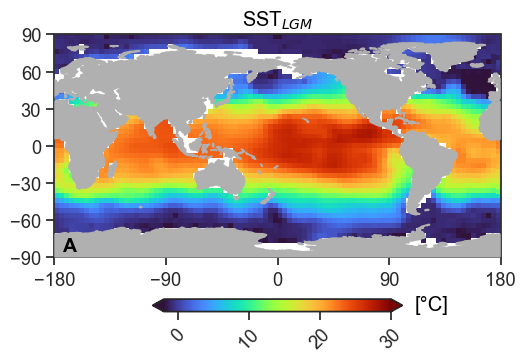

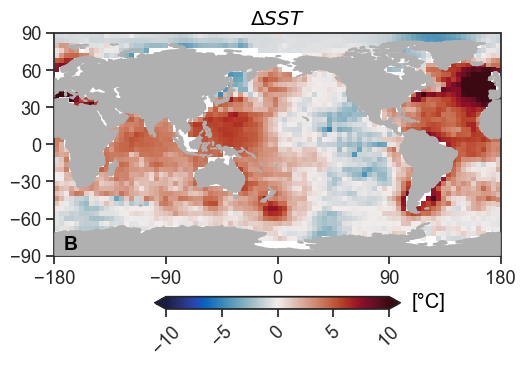

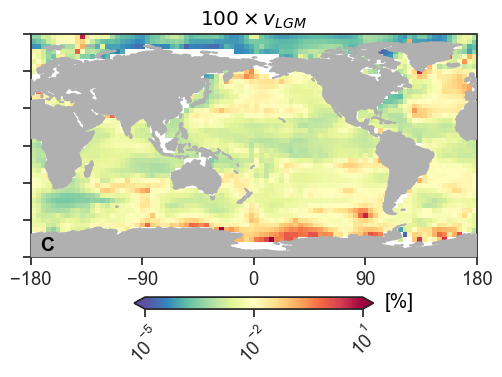

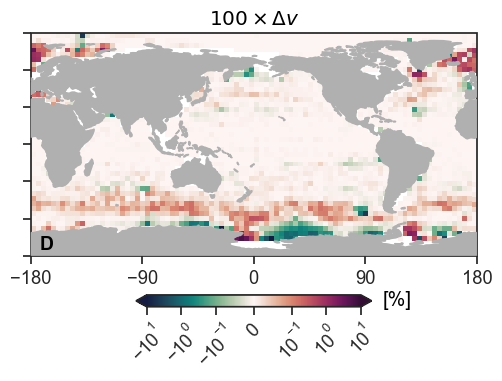

(Figure(<py Figure size 1500x500 with 2 Axes>), <py GeoAxes: title={'center': '$100 \\times \\Delta v$'}>)

In [13]:
###### PLOT LGM SST #######
plot_map_and_zonal(
  γ_lgm.lon, γ_lgm.lat,
  SST_LGM',
  SST_LGM_lat;
  map_norm    = matplotlib.colors.Normalize(vmin=-2, vmax=30),
  cmap        = "turbo",
  map_title   = "SST" * L"_{LGM}",
  cb_label    = "[°C]",
  zonal_xticks= -2:5:30,
  zonal_title = "Zonally Averaged\n" * "SST" * L"_{LGM}",
  savepath    = plotsdir("3A.SST_LGM.png"), plot_letter = "A"
)

###### PLOT ΔSST #######

plot_map_and_zonal(
  γ_lgm.lon, γ_lgm.lat,
  ΔSST',
  ΔSST_lat;
  map_norm    = matplotlib.colors.Normalize(vmin=-10, vmax=10),
  cmap        = cm.balance,
  map_title   = L"\Delta SST ",
  cb_label    = "[°C]",
  zonal_xticks= -1:5,
  zonal_title = "Zonally Averaged\n" * L"\Delta" * "SST",
  savepath    = plotsdir("3B.ΔSST.png"), plot_letter = "B"
)

###### PLOT LGM v #######

plot_map_and_zonal(
  γ_lgm.lon, γ_lgm.lat,
  100 .* v_LGM',
  100 .* lgm_lat_volumes;
  map_norm    = matplotlib.colors.LogNorm(vmin=1e-5, vmax=1e1),
  cmap        = "Spectral_r",
  map_title   = L"100 \times v_{LGM}",
  cb_label    = "[%]",
  zonal_xticks= 0:10:45,
  zonal_title = "Zonally Summed\n" * L"100 \times v_{LGM}",
  savepath    = plotsdir("3C.v_lgm_latitude.png"), plot_letter = "C", hide_yticklabels = true
)

###### PLOT LGM Δv #######
plot_map_and_zonal(
  γ_lgm.lon, γ_lgm.lat,
  100 .* Δv',
  100 .* Δv_lat;
  map_norm    = matplotlib.colors.SymLogNorm(linthresh=1e-1, vmin=-1e1, vmax=1e1),
  cmap        = cm.curl,
  map_title   = L"100 \times \Delta v",
  cb_label    = "[%]",
  zonal_xticks= -30:15:30,
  zonal_title = "Zonally Summed\n" * L"100 \times \Delta v",
  savepath    = plotsdir("3D.Δv_lgm_latitude.png"), plot_letter = "D", hide_yticklabels = true
)

#### Plot MOT spatial decomposition

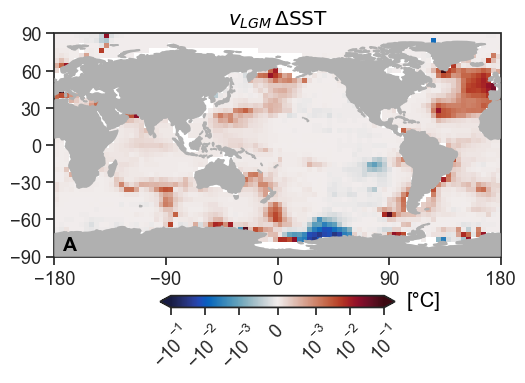

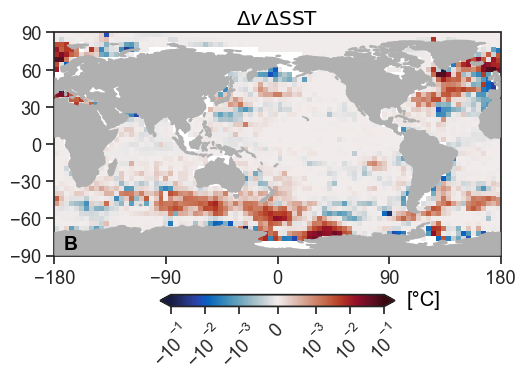

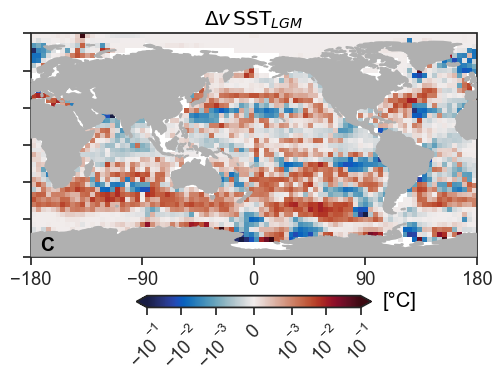

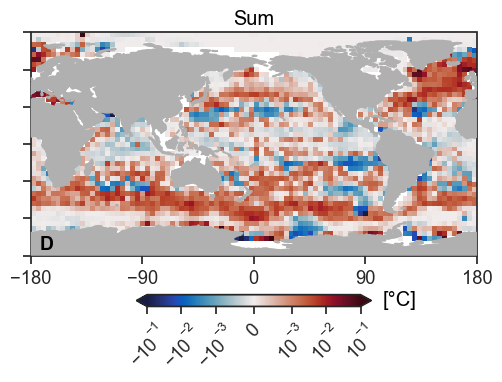

(Figure(<py Figure size 1500x500 with 2 Axes>), <py GeoAxes: title={'center': 'Sum'}>)

In [14]:
norm =  matplotlib.colors.SymLogNorm(linthresh=1e-3, vmin=-1e-1, vmax=1e-1)

plot_map_and_zonal(
  γ_lgm.lon, γ_lgm.lat,
  ΔSST_vlgm', ΔSST_vlgm_lat;
  map_norm    =norm,
  cmap        = cm.balance,
  map_title   = L"v_{LGM}\,\Delta\mathrm{SST}",
  cb_label    = "[°C]",
  zonal_xticks= -0.3:0.15:0.3,
  zonal_title = "Zonally Summed\n" * L"v_{LGM} \Delta SST",
  savepath    = plotsdir("4A.MOT_decomp_vLGM_ΔSST.png"), plot_letter = "A"
)

plot_map_and_zonal(
  γ_lgm.lon, γ_lgm.lat,
  ΔSST_Δv', ΔSST_Δv_lat;
  map_norm    =norm,
  cmap        = cm.balance,
  map_title   = L"\Delta v\,\Delta\mathrm{SST}",
  cb_label    = "[°C]",
  zonal_xticks= -0.3:0.15:0.3,
  zonal_title = "Zonally Summed\n" * L"\Delta v\, \Delta SST",
  savepath    = plotsdir("4B.MOT_decomp_Δv_ΔSST.png"), plot_letter = "B"
)

plot_map_and_zonal(
  γ_lgm.lon, γ_lgm.lat,
  SSTlgm_Δv', SSTlgm_Δv_lat;
  map_norm    =norm,
  cmap        = cm.balance,
  map_title   = L"\Delta v\,\mathrm{SST}_{LGM}",
  cb_label    = "[°C]",
  zonal_xticks= -0.3:0.15:0.3,
  zonal_title = "Zonally Summed\n" * L"\Delta v\, \Delta SST",
  savepath    = plotsdir("4C.MOT_decomp_Δv_SSTLGM.png"), plot_letter = "C", hide_yticklabels = true
)

plot_map_and_zonal(
  γ_lgm.lon, γ_lgm.lat,
  ΔSSTv', ΔSSTv_lat;
  map_norm    =norm,
  cmap        = cm.balance,
  map_title   = "Sum",
  cb_label    = "[°C]",
  zonal_xticks= -0.3:0.15:0.3,
  zonal_title = "Zonally Summed\n" * L"\Delta v\, \Delta SST",
  savepath    = plotsdir("4D.MOT_decomp_SUM.png"), plot_letter = "D", hide_yticklabels = true
)

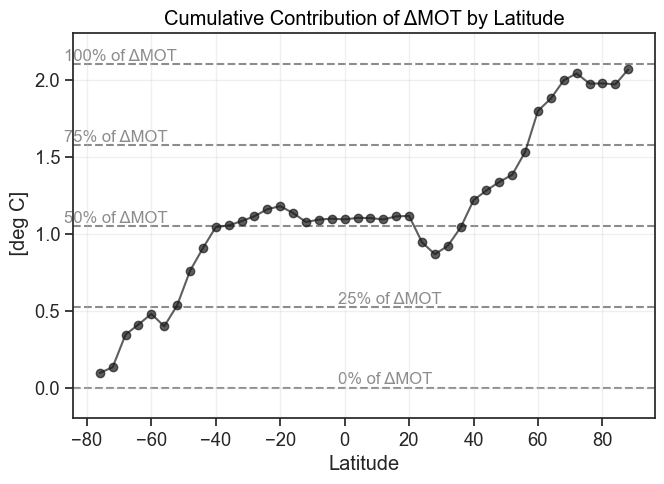

Python: None

In [15]:
vec_cumsum(x) = replace(cumsum(x, dims = 1)[:], 0 => NaN)

fig, ax = subplots(figsize = (7.5, 5)) 

ΔSSTv_lat_cumsum = cumsum(nansum(ΔSSTv, dims = 1)[:])
percentages = [0, 25, 50, 75, 100]

final_value = (θ̄_mod_MOT - θ̄_LGM_MOT)
percentage_values = [final_value * p / 100 for p in percentages]

xlocs = [-5, -5, -90, -90, -90]
for (i, p) in enumerate(percentages)
    val = percentage_values[i]
    lab_alp = 0.9
    # Find the index closest to the percentage value in the cumulative sum
    ax.axhline(y=val, color="gray", linestyle="--", alpha = lab_alp, zorder = 0)
    ax.text(xlocs[i] + 3, val + 0.05, string(p) * "% of ΔMOT", fontsize=12, va="center", ha="left", color = "grey", alpha = lab_alp, zorder = 0)
end

ax.plot(γ_lgm.lat, vec_cumsum(ΔSSTv_lat), marker='o', c = "k", alpha = 0.7)

ax.set_xticks(collect(-80:20:80))
ax.set_ylabel(" [deg C]")

ax.set_xlabel("Latitude")

ax.set_title("Cumulative Contribution of ΔMOT by Latitude")
ax.grid(alpha = 0.3)
ax.set_ylim(-0.2, final_value + 0.2)
fig.savefig(plotsdir("5.dMOT_Latitude_Bins_cumsum.png"), dpi = 200, bbox_inches = "tight")

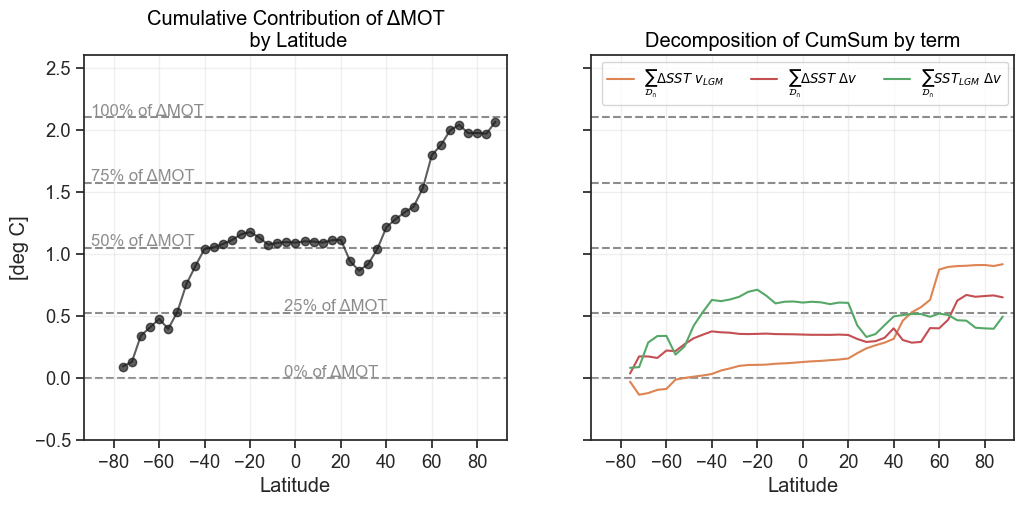

In [16]:
vec_cumsum(x) = replace(cumsum(x, dims = 1)[:], 0 => NaN)
term_label_dict = Dict("regridding_geometry_residual" => "Regridding/\nGeometry\nResidual",
                       "integrand_change" => raw"$\sum_{\mathcal{D}_{\cap}} \Delta SST ~ v_{LGM}$",
                       "weight_change" => raw"$\sum_{\mathcal{D}_{\cap}}  SST_{LGM} ~ \Delta v$",
                       "overlap_interaction" => raw"$\sum_{\mathcal{D}_{\cap}}  \Delta SST ~ \Delta v$",
                       "dMOT" => raw"$\Delta \text{MOT}$")

plot_terms = ["regridding_geometry_residual", "overlap_interaction", "weight_change", "integrand_change", "dMOT"]
colors_terms = sns.color_palette("deep", length(plot_terms)); colors_terms[-1] = "k"
plot_terms = reverse(plot_terms); colors_terms = reverse(collect(colors_terms))


fig, axes = subplots(1, 2, figsize = (12, 5), sharey = true) 

final_value = (θ̄_mod_MOT - θ̄_LGM_MOT)
percentage_values = [final_value * p / 100 for p in percentages]

xlocs = [-5, -5, -90, -90, -90]
percentages = [0, 25, 50, 75, 100]
for (j, a) in enumerate(axes)
    for (i, p) in enumerate(percentages)
        val = percentage_values[i]
        lab_alp = 0.9
        # Find the index closest to the percentage value in the cumulative sum
        a.axhline(y=val, color="gray", linestyle="--", alpha = lab_alp, zorder = 0)
        if j == 1
            a.text(xlocs[i], val + 0.05, string(p) * "% of ΔMOT", fontsize=12, va="center", ha="left", color = "grey", alpha = lab_alp, zorder = 0)
        end
    end
end

ax = axes[0]
ax.plot(γ_lgm.lat, vec_cumsum(ΔSSTv_lat), marker='o', c = "k", alpha = 0.7)
ax.set_title("Cumulative Contribution of ΔMOT\n by Latitude")
ax.set_ylabel("[deg C]")

ax = axes[1]
ax.set_title("Decomposition of CumSum by term")
ax.plot(γ_lgm.lat, vec_cumsum(ΔSST_vlgm_lat), c = colors_terms[4], label = term_label_dict["integrand_change"])
ax.plot(γ_lgm.lat, vec_cumsum(ΔSST_Δv_lat), c = colors_terms[2], label = term_label_dict["overlap_interaction"])
ax.plot(γ_lgm.lat, vec_cumsum(SSTlgm_Δv_lat), c = colors_terms[3], label = term_label_dict["weight_change"])
ax.legend(ncols = 3, fontsize = 9.5)
for a in axes
    a.set_xticks(collect(-80:20:80))
    a.set_xlim(-93, 93)
    a.set_xlabel("Latitude")
    a.grid(alpha = 0.3)
    a.set_ylim(-0.5, final_value + 0.5)
end
# fig.savefig(plotsdir("5.dMOT_Latitude_Bins_cumsum_decomp.png"), dpi = 200, bbox_inches = "tight")